# Classification of Apparel Images Dataset by Modified Pretrained Model
Data Resource : https://www.kaggle.com/trolukovich/apparel-images-dataset

by : Reynold Martua Sinambela

In this task, we will build a model that can classify 11385 apparel images for multi-label/class classification by data from resource mentioned above.

# Import Module

In [1]:
!pip install split_folders

In [2]:
import zipfile
import os 
import splitfolders
import shutil

import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix


import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Source of Pretrained Model
#model_source  = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"
model_source  = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

# Import Data/Images

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
local_zip = '/content/drive/MyDrive/Dicoding - Machine Learning /Apparel.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/Apparel')
zip_ref.close()

## Merge Folder and Reduce The Number of Class
From images in the dataset, there are 24 multi-class which is feature-cross between apparels and colors. In this tasks, we will reduce the label by merging the data per apparel. Therefore, we obtain five new label which are shirt, dress, pants, shorts, and shoes.

In [5]:
# Create New Folder
os.mkdir("/tmp/New Apparel/", 0o777) 

# Function to merge folder
def create_new_folder(folder_name, parent_folder):
    path = os.path.join(parent_folder, folder_name)
    try: 
        mode = 0o777
        os.mkdir(path, mode) 
    except OSError as error: 
        print(error)
  
def merge(list_dir,merge_folder):
  current_folder = "/tmp/New Apparel/" 
  content_list = {}
  for index, val in enumerate(list_dir):
      path = os.path.join(current_folder, val)
      content_list[ list_dir[index] ] = os.listdir(path)
       
  merge_folder_path = os.path.join(current_folder, merge_folder)    
  create_new_folder(merge_folder, current_folder)   
  for sub_dir in content_list:
      for contents in content_list[sub_dir]:
          path_to_content = sub_dir + "/" + contents  
          dir_to_move = os.path.join(current_folder, path_to_content )
          shutil.move(dir_to_move, merge_folder_path)

In [6]:
list_dir = [['/tmp/Apparel/black_dress', '/tmp/Apparel/blue_dress', '/tmp/Apparel/white_dress','/tmp/Apparel/red_dress'],
            ['/tmp/Apparel/black_pants', '/tmp/Apparel/blue_pants', '/tmp/Apparel/white_pants','/tmp/Apparel/red_pants','/tmp/Apparel/green_pants','/tmp/Apparel/brown_pants'],
            ['/tmp/Apparel/black_shirt', '/tmp/Apparel/blue_shirt', '/tmp/Apparel/green_shirt'],
            ['/tmp/Apparel/black_shorts', '/tmp/Apparel/blue_shorts', '/tmp/Apparel/white_shorts','/tmp/Apparel/green_shorts','/tmp/Apparel/brown_shorts'],
            ['/tmp/Apparel/black_shoes', '/tmp/Apparel/blue_shoes', '/tmp/Apparel/white_shoes','/tmp/Apparel/red_shoes','/tmp/Apparel/green_shoes','/tmp/Apparel/brown_shoes']]

merge_folder = ["dress", "pants","shirt","shorts","shoes"]
for i in range(len(merge_folder)):
  merge(list_dir[i],merge_folder[i])

# Splitting Data

In [7]:
# Split Image to 80% as train data, and the rest as validation data
splitfolders.ratio('/tmp/New Apparel', output="/tmp/images", seed=1337, ratio=(.8, .2))

# Directory
base_dir = '/tmp/images'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

Copying files: 11385 files [00:01, 6034.91 files/s]


We have 11385 images.

# Data Visualization
Visualize some images with its size.

In [8]:
kategori = os.listdir('/tmp/New Apparel')
value    = [len(os.listdir('/tmp/New Apparel/' + folder)) for folder in kategori]
kategori

['shirt', 'shorts', 'pants', 'dress', 'shoes']

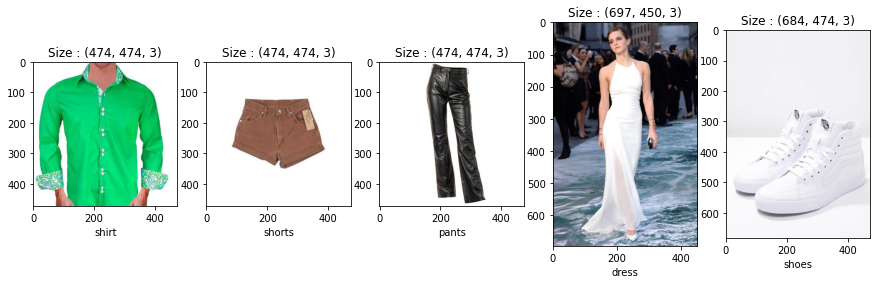

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=len(kategori),figsize = (15,20))

for i in range(len(kategori)):
  path = "/tmp/New Apparel/" + kategori[i]
  list_gambar = os.listdir(path)

  indeks = np.random.randint(value[i])

  img = mpimg.imread(path + "/" + list_gambar[indeks])
  ax[i].imshow(img)
  ax[i].set_title("Size : "+str(img.shape))
  ax[i].set(xlabel=kategori[i])

In the plot and its detailed above, we can see the number of images from each class with different size.

# Data Preprocessing

In [10]:
# Size of Resized Image
size = [224,224]

## Data Augmentation
In this section, we create an ImageDataGenerator object to do image augmentation by rescaling, rotation, shifting width and height, flipping, and zooming images.

In [11]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = .2,
                    fill_mode = 'nearest')
  
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = .2,
                    fill_mode = 'nearest')

In [12]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size = size, 
        batch_size = 32,
        shuffle = False,
        class_mode = 'categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir, 
        target_size = size,
        batch_size = 32,
        shuffle = False,
        class_mode = 'categorical')

Found 9106 images belonging to 5 classes.
Found 2279 images belonging to 5 classes.


# Model
## Model Architecture
Here we create the sequential model by transfer learning with TensorFlow Hub by using MobileNetV2.

In [13]:
model = tf.keras.Sequential([tf.keras.layers.MaxPool2D((1,1),padding = 'same'),
                             hub.KerasLayer(model_source),
                             tf.keras.layers.Dense(5,activation="softmax")
                             ])

model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
model.build([None,224, 224, 3])

## Model Summary

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d (MaxPooling2D) (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 5)                 5010      
Total params: 5,437,723
Trainable params: 5,010
Non-trainable params: 5,432,713
_________________________________________________________________


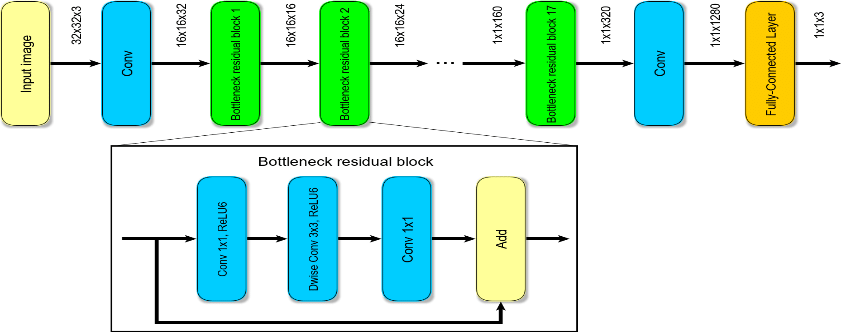

Image Source : https://www.researchgate.net/figure/The-architecture-of-the-MobileNetv2-network_fig3_342856036

As we can see in the figure above, this pretrained model called MobileNetV2 consists of Convolution with ReLU, The depthwise Conv with Bottleneck Residual Block and Convolution without any Non-Linearity. In order to meet the requirements of Dicoding subsmission, we add the layer of MaxPooling2D in the layer before the pretrained model and also add Fully Connected Layer with 5 neurons as the output for classification.

## Optimizer

## Callback
We create two callback as explained below.
- __Early stopping__ that will stop the training phase if the model accuracy and loss have met the condition required.
- __Adaptive learning__ to make adaptive learning rate in training process.

In [15]:
min_acc = 0.94 ; max_loss = 0.15

class StopCond(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>min_acc and logs.get('loss')<max_loss and logs.get('val_accuracy')>min_acc and logs.get('val_loss')<max_loss):
      print("\n Accuracy and Loss condition have been satisfied.")
      self.model.stop_training = True

early_stopping    = StopCond()
adaptive_learning = ReduceLROnPlateau(patience = 2, verbose = 2, factor = 0.5, min_lr = 0.000003)

## Train Model

In [16]:
start_time = time.time()

In [17]:
history = model.fit(train_generator, validation_data = validation_generator, epochs = 50, callbacks = [early_stopping,adaptive_learning])

Epoch 1/50
285/285 [==============================] - 182s 525ms/step - loss: 0.5300 - accuracy: 0.8214 - val_loss: 0.2425 - val_accuracy: 0.9153
Epoch 2/50
285/285 [==============================] - 148s 518ms/step - loss: 0.2116 - accuracy: 0.9255 - val_loss: 0.1854 - val_accuracy: 0.9399
Epoch 3/50
285/285 [==============================] - 148s 521ms/step - loss: 0.1890 - accuracy: 0.9370 - val_loss: 0.1895 - val_accuracy: 0.9359
Epoch 4/50
285/285 [==============================] - 148s 521ms/step - loss: 0.1765 - accuracy: 0.9420 - val_loss: 0.1573 - val_accuracy: 0.9491
Epoch 5/50
285/285 [==============================] - 148s 521ms/step - loss: 0.1630 - accuracy: 0.9445 - val_loss: 0.1667 - val_accuracy: 0.9465
Epoch 6/50
285/285 [==============================] - 148s 521ms/step - loss: 0.1605 - accuracy: 0.9439 - val_loss: 0.1713 - val_accuracy: 0.9469

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
285/285 [=======================

In [18]:
end_time = time.time()
durasi = (end_time - start_time)/60

print("Time Elapsed for trainig model : ",durasi,"minutes.")

Time Elapsed for trainig model :  18.77862667242686 minutes.


## History of Model Accuracy and Loss

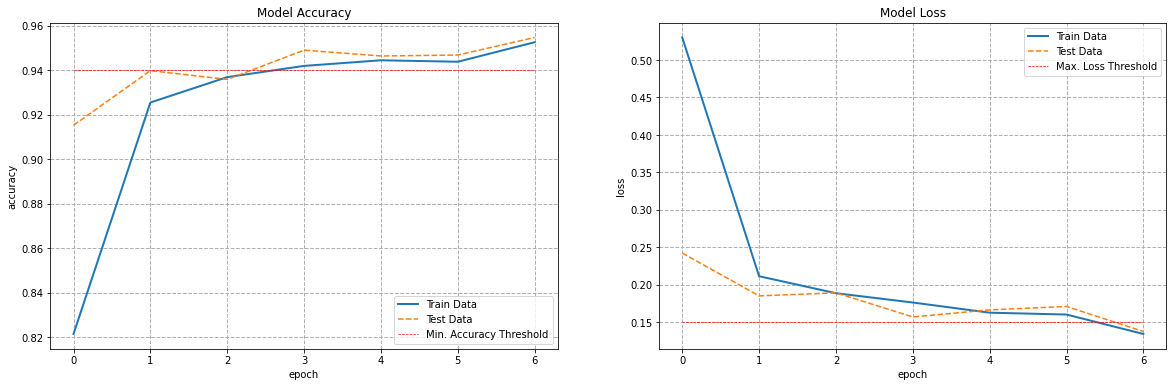

In [19]:
def plot_trained_model_history(trained_model,min_acc,max_loss):
    acc     = trained_model.history['accuracy']
    val_acc = trained_model.history['val_accuracy']

    loss     = trained_model.history['loss']
    val_loss = trained_model.history['val_loss']

    plt.figure(figsize=(20, 6))

    length   = len(acc)
    min_acc  = [min_acc]*length
    max_loss = [max_loss]*length

    # Grafik Nilai Akurasi
    plt.subplot(1, 2, 1)
    plt.title('Model Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(acc, label='Train Data',linewidth=2)
    plt.plot(val_acc, label='Test Data', linestyle='--')
    plt.plot(min_acc, label='Min. Accuracy Threshold',linestyle='--',color='red',linewidth=.7)
    plt.legend()
    plt.grid(linestyle='--', linewidth=1)

    # Grafik Nilai Loss
    plt.subplot(1, 2, 2)
    plt.title('Model Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(loss, label='Train Data',linewidth=2)
    plt.plot(val_loss, label='Test Data', linestyle='--')
    plt.plot(max_loss, label='Max. Loss Threshold',linestyle='--',color='red',linewidth=.7)
    plt.legend()
    plt.grid(linestyle='--', linewidth=1)

    plt.show()

plot_trained_model_history(history,min_acc,max_loss)

# Model Evaluation

In [20]:
target_names = list(train_generator.class_indices.keys())

## Confusion Matrix & Classification Report of Train Data

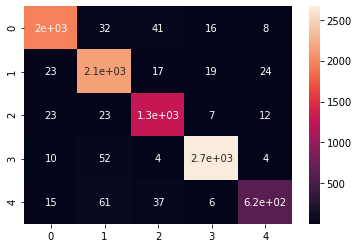

In [22]:
Y_pred = model.predict(train_generator, train_generator.n // 32+1)
y_pred = np.argmax(Y_pred, axis=1)
sns.heatmap(confusion_matrix(train_generator.classes, y_pred), annot=True)

In [23]:
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       dress       0.97      0.95      0.96      2056
       pants       0.93      0.96      0.94      2231
       shirt       0.93      0.95      0.94      1348
       shoes       0.98      0.97      0.98      2734
      shorts       0.93      0.84      0.88       737

    accuracy                           0.95      9106
   macro avg       0.95      0.94      0.94      9106
weighted avg       0.95      0.95      0.95      9106



## Confusion Matrix & Classification Report of Test Data

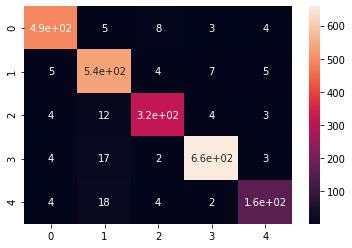

In [24]:
Y_pred = model.predict(validation_generator, validation_generator.n // 32+1)
y_pred = np.argmax(Y_pred, axis=1)
sns.heatmap(confusion_matrix(validation_generator.classes, y_pred), annot=True)

In [25]:
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       dress       0.97      0.96      0.96       514
       pants       0.91      0.96      0.94       558
       shirt       0.95      0.93      0.94       338
       shoes       0.98      0.96      0.97       684
      shorts       0.91      0.85      0.88       185

    accuracy                           0.95      2279
   macro avg       0.94      0.93      0.94      2279
weighted avg       0.95      0.95      0.95      2279



# Converting Model to TF-Lite Format

In [26]:
# model conversion
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpl9fy7kgb/assets


INFO:tensorflow:Assets written to: /tmp/tmpl9fy7kgb/assets


In [27]:
# saving in .tflite() format
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)